In [0]:
import numpy as np 
import pandas as pd

In [0]:
from google.colab import drive 
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!cp "/content/gdrive/My Drive/Security Dataset/Trimmed Dataset-20200612T201236Z-001.zip" "/content/"

In [0]:
!unzip "/content/Trimmed Dataset-20200612T201236Z-001.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Trimmed Dataset/Burglary/Burglary011_x264_29.mp4  
  inflating: Trimmed Dataset/Arson/Arson034_x264_19.mp4  
  inflating: Trimmed Dataset/Burglary/Burglary066_x264_14.mp4  
  inflating: Trimmed Dataset/Burglary/Burglary071_x264_22.mp4  
  inflating: Trimmed Dataset/Arrest/Arrest036_x264_29.mp4  
  inflating: Trimmed Dataset/Burglary/Burglary071_x264_13.mp4  
  inflating: Trimmed Dataset/Burglary/Burglary037_x264_22.mp4  
  inflating: Trimmed Dataset/Arrest/Arrest017_x264_29.mp4  
  inflating: Trimmed Dataset/Burglary/Burglary014_x264_29.mp4  
  inflating: Trimmed Dataset/Vandalism/Vandalism038_x264_30.mp4  
  inflating: Trimmed Dataset/Burglary/Burglary069_x264_11.mp4  
  inflating: Trimmed Dataset/Stealing/Stealing018_x264_18.mp4  
  inflating: Trimmed Dataset/Burglary/Burglary069_x264_2.mp4  
  inflating: Trimmed Dataset/Vandalism/Vandalism044_x264_9.mp4  
  inflating: Trimmed Dataset/Vandalism/Vandalism040_x264_3.mp4  


In [0]:
import os
path="/content/curated_dataset/"
count=0
for i in os.listdir(path):
  count=0
  for j in os.listdir(path+str(i)):
    count=count+1
  print(i+":",count)

FileNotFoundError: ignored

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files

In [0]:
!mkdir curated_dataset
!cp -r "/content/Trimmed Dataset/Vandalism" "/content/curated_dataset"
!cp -r "/content/Trimmed Dataset/Normal" "/content/curated_dataset"





In [0]:
#for making the class balance
count=0
import random
import shutil
for i in os.listdir("/content/curated_dataset/Normal"):
  a=random.choice(os.listdir("/content/curated_dataset/Normal"))
  os.remove("/content/curated_dataset/Normal/"+str(a))
  count=count+1
  if count==794:
    break


In [0]:
raw_data=load_files(os.getcwd()+r'/curated_dataset/', shuffle=True)
files=raw_data['filenames']
targets=raw_data['target']

train_files, test_files, train_targets, test_targets=train_test_split(files, targets, test_size=1/3, random_state=191)


In [0]:
len(train_files)

538

In [0]:
valid_files = train_files[500:]
valid_targets = train_targets[500:]

# Remaining data will be used for training the model
train_files = train_files[:500]
train_targets = train_targets[:500]

# Generic details about the data
print('Total number of videos:', len(files))
print('\nNumber of videos in training data:', train_files.shape[0])
print('Number of videos in validation data:', valid_files.shape[0])
print('Number of videos in test data:', test_files.shape[0])

Total number of videos: 808

Number of videos in training data: 500
Number of videos in validation data: 38
Number of videos in test data: 270


In [0]:
print('The categorical labels are converted into integers.\nFollowing is the mapping - \n')
for label in zip(range(14), raw_data['target_names']):
    print(label)



The categorical labels are converted into integers.
Following is the mapping - 

(0, 'Normal')
(1, 'Vandalism')


In [0]:
for pair in zip(train_files[:5], train_targets[:5]):
    print(pair)



('/content/curated_dataset/Vandalism/Vandalism030_x264_12.mp4', 1)
('/content/curated_dataset/Normal/Robbery052_x264_14.mp4', 0)
('/content/curated_dataset/Normal/Robbery093_x264_21.mp4', 0)
('/content/curated_dataset/Vandalism/Vandalism004_x264_4.mp4', 1)
('/content/curated_dataset/Vandalism/Vandalism040_x264_6.mp4', 1)


In [0]:
!pip install scikit-video

     |████████████████████████████████| 2.3MB 2.8MB/s 


In [0]:
import numpy as np
from skvideo.io import FFmpegReader, ffprobe
from skvideo.utils import rgb2gray
from PIL import Image
from keras.preprocessing import image
from tqdm import tqdm
import matplotlib.pyplot as plt


class Videos(object):

    def __init__(self, target_size=None, to_gray=True, max_frames=None,
                 extract_frames='middle', required_fps=None,
                 normalize_pixels=None):
        """
        Initializing the config variables

        Parameters:
            target_size (tuple): (New_Width, New_Height), Default 'None'
                A tuple denoting the target width and height of each frame in each of the video

            to_gray (boolean): Default 'True'
                If True, then each frame will be converted to gray scale. Otherwise, not.

            max_frames (int): Default 'None'
                The maximum number of frames to return for each video.
                Extra frames are removed based on the value of 'extract_frames'.

            extract_frames (str): {'first', 'middle', 'last'}, Default 'middle'
                'first': Extract the first 'N' frames

                'last': Extract the last 'N' frames

                'middle': Extract 'N' frames from the middle
                    Remove ((total_frames - max_frames) // 2) frames from the beginning as well as the end

            required_fps (int): Default 'None'
                Capture 'N' frame(s) per second from the video.

                Only the first 'N' frame(s) for each second in the video are captured.

            normalize_pixels (tuple/str): Default 'None'
                If 'None', the pixels will not be normalized.

                If a tuple - (New_min, New_max) is passed, Min-max Normalization will be used.

                If the value is 'z-score', then Z-score Normalization will be used.
                For each pixel p, z_score = (p - mean) / std
        """

        self.target_size = target_size
        self.to_gray = to_gray
        self.max_frames = max_frames
        self.extract_frames = extract_frames
        self.required_fps = required_fps
        self.normalize_pixels = normalize_pixels
        self.fps = None

    def read_videos(self, paths):
        """
        Parameters:
            paths (list): Required
                 A list of paths of the videos to be read

        Returns:
            Numpy.ndarray
                A 5-d tensor with shape (<No. of Videos>, <No. of frames>, <height>, <width>, <channels>)
        """

        list_of_videos = [
            self._read_video(path) for path in tqdm(paths)
        ]

        tensor = np.vstack(list_of_videos)

        if self.normalize_pixels != None:
            # Pixels are normalized for each video individually
            if (type(self.normalize_pixels) == tuple) and (len(self.normalize_pixels) == 2):
                base = self.normalize_pixels[0]
                r = self.normalize_pixels[1] - base
                min_ = np.min(tensor, axis=(1, 2, 3), keepdims=True)
                max_ = np.max(tensor, axis=(1, 2, 3), keepdims=True)
                return ((tensor.astype('float32') - min_) / (max_ - min_)) * r + base

            elif self.normalize_pixels == 'z-score':
                mean = np.mean(tensor, axis=(1, 2, 3), keepdims=True)
                std = np.std(tensor, axis=(1, 2, 3), keepdims=True)
                return (tensor.astype('float32') - mean) / std
            
            else:
                raise ValueError('Invalid value of \'normalize_pixels\'')

        return tensor

    def get_frame_count(self, paths):
        """
        Can be used to determine the value of `max_frames`

        Parameters:
            paths (list): Required
                 A list of paths of the videos to be read

        Returns:
            dict (python dictionary)
                For each video, the total number of frames in that video is stored in the dictionary.
        """

        frame_count = {}
        for path in paths:
            cap = FFmpegReader(filename=path)
            frame_count[path] = cap.inputframenum
            cap.close()

        return frame_count

    def _read_video(self, path):
        """
        Parameters:
            path (str): Required
                Path of the video to be read

        Returns:
            Numpy.ndarray
                A 5-d tensor with shape (1, <No. of frames>, <height>, <width>, <channels>)
        """

        cap = FFmpegReader(filename=path)
        list_of_frames = []
        self.fps = int(cap.inputfps)                  # Frame Rate

        for index, frame in enumerate(cap.nextFrame()):

            capture_frame = True
            if self.required_fps != None:
                is_valid = range(self.required_fps)
                capture_frame = (index % self.fps) in is_valid

            if capture_frame:

                if self.target_size is not None:
                    temp_image = image.array_to_img(frame)
                    frame = image.img_to_array(
                        temp_image.resize(
                            self.target_size,
                            Image.ANTIALIAS)).astype('uint8')

                # Shape of each frame -> (<height>, <width>, 3)
                list_of_frames.append(frame)

        temp_video = np.stack(list_of_frames)
        cap.close()

        if self.to_gray:
            temp_video = rgb2gray(temp_video)
                
        if self.max_frames is not None:
            temp_video = self._process_video(video=temp_video)

        return np.expand_dims(temp_video, axis=0)

    def _process_video(self, video):
        """
        Parameters:
            video (Numpy.ndarray):
                Shape = (<No. of frames>, <height>, <width>, <channels>)

                Video whose frames are to be extracted

        Returns:
            Numpy.ndarray
                A tensor (processed video) with shape (<`max_frames`>, <height>, <width>, <channels>)
        """

        total_frames = video.shape[0]
        if self.max_frames <= total_frames:

            if self.extract_frames == 'first':
                video = video[:self.max_frames]
            elif self.extract_frames == 'last':
                video = video[(total_frames - self.max_frames):]
            elif self.extract_frames == 'middle':
                # No. of frames to remove from the front
                front = ((total_frames - self.max_frames) // 2) + 1
                video = video[front:(front + self.max_frames)]
            else:
                raise ValueError('Invalid value of \'extract_frames\'')

        else:
            raise IndexError(
                'Required number of frames is greater than the total number of frames in the video')

        return video


Using TensorFlow backend.


100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


Shape of the sample data: (1, 30, 240, 320, 3)


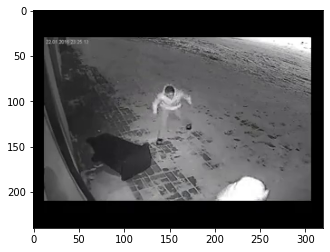

In [0]:

# The path of a sample video in the training data
sample_files = train_files[:1]

# An object of the class 'Videos'
reader = Videos(target_size=None, 
                to_gray=False)

# Loading the sample videos, in their original format
sample = reader.read_videos(sample_files)
print('\nShape of the sample data:', sample.shape)

# Displaying a frame from the sample video
plt.imshow(sample[0][29])



In [0]:
import numpy as np
from keras.utils import to_categorical


# An object of the class `Videos` to load the data in the required format
reader = Videos(target_size=(128, 128), 
                to_gray=True, 
                max_frames=29, 
                extract_frames='middle', 
                normalize_pixels=(0, 1))

In [0]:
# Reading training videos and one-hot encoding the training labels
X_train = reader.read_videos(train_files)
y_train = to_categorical(train_targets, num_classes=2)
print('Shape of training data:', X_train.shape)
print('Shape of training labels:', y_train.shape)




100%|██████████| 500/500 [02:55<00:00,  2.85it/s]


Shape of training data: (500, 29, 128, 128, 1)
Shape of training labels: (500, 2)


In [0]:
# Reading validation videos and one-hot encoding the validation labels
X_valid = reader.read_videos(valid_files)
y_valid = to_categorical(valid_targets, num_classes=2)
print('Shape of validation data:', X_valid.shape)
print('Shape of validation labels:', y_valid.shape)




100%|██████████| 38/38 [00:16<00:00,  2.30it/s]

Shape of validation data: (38, 29, 128, 128, 1)
Shape of validation labels: (38, 2)


In [0]:
X_test = reader.read_videos(test_files)
y_test = to_categorical(test_targets, num_classes=2)
print('Shape of testing data:', X_test.shape)
print('Shape of testing labels:', y_test.shape)


100%|██████████| 270/270 [01:50<00:00,  2.44it/s]


Shape of testing data: (270, 29, 128, 128, 1)
Shape of testing labels: (270, 2)


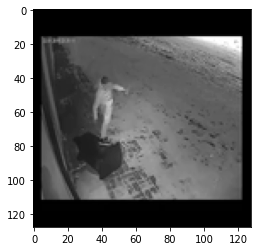

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# After pre-processing

# Displaying the first frame of the first processed video from the training data
plt.imshow(np.squeeze(X_train[0][0], axis=2), cmap='gray')

In [0]:
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D
from keras.layers.core import Dense
import tensorflow.keras.backend as K

# Using the Sequential Model
model = Sequential()

# Adding Alternate convolutional and pooling layers
model.add(Conv3D(filters=16, kernel_size=(10, 3, 3), strides=(1, 1, 1), padding='same', activation='relu', 
                 input_shape=X_train.shape[1:]))
model.add(MaxPooling3D(pool_size=2, strides=(1, 2, 2), padding='same'))

model.add(Conv3D(filters=64, kernel_size=(5, 3, 3), strides=(3, 1, 1), padding='valid', activation='relu'))
model.add(MaxPooling3D(pool_size=2, strides=(1, 2, 2), padding='same'))

model.add(Conv3D(filters=256, kernel_size=(5, 3, 3), strides=(3, 1, 1), padding='valid', activation='relu'))
model.add(MaxPooling3D(pool_size=2, strides=(1, 2, 2), padding='same'))

# A global average pooling layer to get a 1-d vector
# The vector will have a depth (same as number of elements in the vector) of 256
model.add(GlobalAveragePooling3D())

# The Global average pooling layer is followed by a fully-connected neural network, with one hidden and one output layer

# Hidden Layer
model.add(Dense(32, activation='relu'))

# Output layer
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 29, 128, 128, 16)  1456      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 29, 64, 64, 16)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 9, 62, 62, 64)     46144     
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 9, 31, 31, 64)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 2, 29, 29, 256)    737536    
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 2, 15, 15, 256)    0         
_________________________________________________________________
global_average_pooling3d_1 ( (None, 256)              

In [0]:
from keras.callbacks import ModelCheckpoint

# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Saving the model that performed the best on the validation set
checkpoint = ModelCheckpoint(filepath='Model_1_vandalism.weights.best.hdf5', save_best_only=True, verbose=1)

# Training the model for 40 epochs
history = model.fit(X_train, y_train, batch_size=16, epochs=40, 
                    validation_data=(X_valid, y_valid), verbose=2, callbacks=[checkpoint])

Train on 500 samples, validate on 38 samples
Epoch 1/40
 - 14s - loss: 0.6932 - accuracy: 0.5360 - val_loss: 0.6952 - val_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 0.69518, saving model to Model_1_vandalism.weights.best.hdf5
Epoch 2/40
 - 6s - loss: 0.6809 - accuracy: 0.5380 - val_loss: 0.6845 - val_accuracy: 0.5263

Epoch 00002: val_loss improved from 0.69518 to 0.68449, saving model to Model_1_vandalism.weights.best.hdf5
Epoch 3/40
 - 6s - loss: 0.6531 - accuracy: 0.6180 - val_loss: 0.6196 - val_accuracy: 0.6579

Epoch 00003: val_loss improved from 0.68449 to 0.61956, saving model to Model_1_vandalism.weights.best.hdf5
Epoch 4/40
 - 6s - loss: 0.6078 - accuracy: 0.6560 - val_loss: 0.6364 - val_accuracy: 0.5789

Epoch 00004: val_loss did not improve from 0.61956
Epoch 5/40
 - 6s - loss: 0.4932 - accuracy: 0.7460 - val_loss: 0.6348 - val_accuracy: 0.7105

Epoch 00005: val_loss did not improve from 0.61956
Epoch 6/40
 - 6s - loss: 0.5603 - accuracy: 0.6920 - val_loss:

In [0]:
# Loading the model that performed the best on the validation set
model.load_weights('/content/Model_1_vandalism.weights.best.hdf5')

# Testing the model on the Test data
(loss, accuracy) = model.evaluate(X_test, y_test, batch_size=16, verbose=0)

print('Accuracy on test data: {:.2f}%'.format(accuracy * 100))



Accuracy on test data: 95.19%


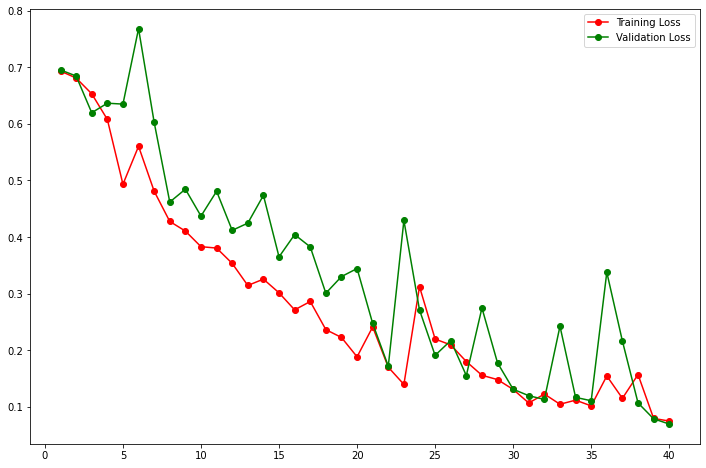

In [0]:
# Making the plot larger
plt.figure(figsize=(12, 8))

loss = history.history['loss']                          # Loss on the training data
val_loss = history.history['val_loss']                  # Loss on the validation data
epochs = range(1, 41)

plt.plot(epochs, loss, 'ro-', label='Training Loss')
plt.plot(epochs, val_loss, 'go-', label = 'Validation Loss')
plt.legend()



In [0]:
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D
from keras.layers.core import Dense, Dropout

# Using the Sequential Model
model = Sequential()

# Adding Alternate convolutional and pooling layers
model.add(Conv3D(filters=16, kernel_size=(10, 3, 3), strides=(1, 1, 1), padding='same', activation='relu', 
                 input_shape=X_train.shape[1:]))
model.add(MaxPooling3D(pool_size=2, strides=(1, 2, 2), padding='same'))

model.add(Conv3D(filters=64, kernel_size=(5, 3, 3), strides=(3, 1, 1), padding='valid', activation='relu'))
model.add(MaxPooling3D(pool_size=2, strides=(1, 2, 2), padding='same'))

model.add(Conv3D(filters=256, kernel_size=(5, 3, 3), strides=(3, 1, 1), padding='valid', activation='relu'))
model.add(MaxPooling3D(pool_size=2, strides=(1, 2, 2), padding='same'))

# A global average pooling layer to get a 1-d vector
# The vector will have a depth (same as number of elements in the vector) of 256
model.add(GlobalAveragePooling3D())

# Hidden layer
model.add(Dense(32, activation='relu'))

# Dropout Layer
model.add(Dropout(0.5))

# Output layer
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 29, 128, 128, 16)  1456      
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 29, 64, 64, 16)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 9, 62, 62, 64)     46144     
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 9, 31, 31, 64)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 2, 29, 29, 256)    737536    
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 2, 15, 15, 256)    0         
_________________________________________________________________
global_average_pooling3d_2 ( (None, 256)              

In [0]:
# Imports
from keras.callbacks import ModelCheckpoint

# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Saving the model that performed the best on the validation set
checkpoint = ModelCheckpoint(filepath='Model_2.weights.best.hdf5', save_best_only=True, verbose=1)

# Training the model for 40 epochs
history = model.fit(X_train, y_train, batch_size=16, epochs=40, 
                    validation_data=(X_valid, y_valid), verbose=2, callbacks=[checkpoint])



Train on 500 samples, validate on 38 samples
Epoch 1/40
 - 6s - loss: 0.6883 - accuracy: 0.5000 - val_loss: 0.6924 - val_accuracy: 0.6579

Epoch 00001: val_loss improved from inf to 0.69240, saving model to Model_2.weights.best.hdf5
Epoch 2/40
 - 6s - loss: 0.7027 - accuracy: 0.5200 - val_loss: 0.6886 - val_accuracy: 0.5263

Epoch 00002: val_loss improved from 0.69240 to 0.68858, saving model to Model_2.weights.best.hdf5
Epoch 3/40
 - 6s - loss: 0.6933 - accuracy: 0.5140 - val_loss: 0.6929 - val_accuracy: 0.5000

Epoch 00003: val_loss did not improve from 0.68858
Epoch 4/40
 - 6s - loss: 0.6934 - accuracy: 0.5520 - val_loss: 0.6911 - val_accuracy: 0.5526

Epoch 00004: val_loss did not improve from 0.68858
Epoch 5/40
 - 6s - loss: 0.6814 - accuracy: 0.5820 - val_loss: 0.6675 - val_accuracy: 0.5000

Epoch 00005: val_loss improved from 0.68858 to 0.66753, saving model to Model_2.weights.best.hdf5
Epoch 6/40
 - 6s - loss: 0.6883 - accuracy: 0.5580 - val_loss: 0.6724 - val_accuracy: 0.5000


In [0]:
model.load_weights('Model_2.weights.best.hdf5')

# Testing the model on the Test data
(loss, accuracy) = model.evaluate(X_test, y_test, batch_size=16, verbose=0)

print('Accuracy on test data: {:.2f}%'.format(accuracy * 100))

Accuracy on test data: 86.30%


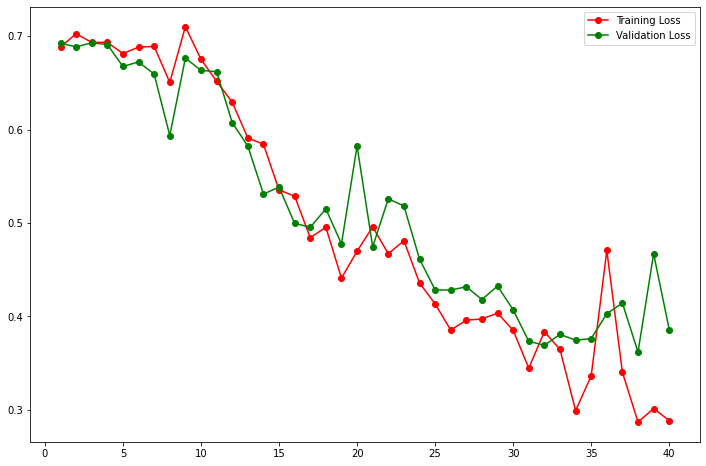

In [0]:
# Making the plot larger
plt.figure(figsize=(12, 8))

loss = history.history['loss']                          # Loss on the training data
val_loss = history.history['val_loss']                  # Loss on the validation data
epochs = range(1, 41)

plt.plot(epochs, loss, 'ro-', label='Training Loss')
plt.plot(epochs, val_loss, 'go-', label = 'Validation Loss')
plt.legend()



In [0]:
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, GlobalAveragePooling3D, BatchNormalization
from keras.layers.core import Dense, Dropout

# Using the Sequential Model
model = Sequential()

# Adding Alternate convolutional and pooling layers
model.add(Conv3D(filters=16, kernel_size=(5, 3, 3), strides=(1, 1, 1), padding='same', activation='relu', 
                 input_shape=X_train.shape[1:]))
model.add(MaxPooling3D(pool_size=2, strides=(2, 2, 2), padding='same'))

model.add(Conv3D(filters=64, kernel_size=(2, 3, 3), strides=(1, 1, 1), padding='valid', activation='relu'))
model.add(MaxPooling3D(pool_size=2, strides=(2, 2, 2), padding='same'))

model.add(Conv3D(filters=256, kernel_size=(2, 3, 3), strides=(1, 1, 1), padding='valid', activation='relu'))
model.add(MaxPooling3D(pool_size=2, strides=(2, 2, 2), padding='same'))

model.add(Conv3D(filters=1024, kernel_size=(2, 3, 3), strides=(1, 1, 1), padding='valid', activation='relu'))
model.add(MaxPooling3D(pool_size=2, strides=(2, 2, 2), padding='same'))

# A global average pooling layer to get a 1-d vector
# The vector will have a depth (same as number of elements in the vector) of 1024
model.add(GlobalAveragePooling3D())

# Hidden layer
model.add(Dense(32, activation='relu'))

# Dropout Layer
model.add(Dropout(0.5))

# Output layer
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_7 (Conv3D)            (None, 29, 128, 128, 16)  736       
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 15, 64, 64, 16)    0         
_________________________________________________________________
conv3d_8 (Conv3D)            (None, 14, 62, 62, 64)    18496     
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 7, 31, 31, 64)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 6, 29, 29, 256)    295168    
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 3, 15, 15, 256)    0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 2, 13, 13, 1024)  

In [0]:
from keras.callbacks import ModelCheckpoint

# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

# Saving the model that performed the best on the validation set
checkpoint = ModelCheckpoint(filepath='Model_3.weights.best.hdf5', save_best_only=True, verbose=1)

# Training the model for 40 epochs
history = model.fit(X_train, y_train, batch_size=16, epochs=40, 
                    validation_data=(X_valid, y_valid), verbose=2, callbacks=[checkpoint])

Train on 500 samples, validate on 38 samples
Epoch 1/40
 - 8s - loss: 0.8551 - accuracy: 0.5380 - val_loss: 0.7535 - val_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 0.75350, saving model to Model_3.weights.best.hdf5
Epoch 2/40
 - 7s - loss: 0.7116 - accuracy: 0.5000 - val_loss: 0.6875 - val_accuracy: 0.5000

Epoch 00002: val_loss improved from 0.75350 to 0.68751, saving model to Model_3.weights.best.hdf5
Epoch 3/40
 - 7s - loss: 0.6854 - accuracy: 0.5460 - val_loss: 0.6852 - val_accuracy: 0.5000

Epoch 00003: val_loss improved from 0.68751 to 0.68518, saving model to Model_3.weights.best.hdf5
Epoch 4/40
 - 7s - loss: 0.6840 - accuracy: 0.5820 - val_loss: 0.6939 - val_accuracy: 0.5000

Epoch 00004: val_loss did not improve from 0.68518
Epoch 5/40
 - 7s - loss: 0.8111 - accuracy: 0.5640 - val_loss: 0.7324 - val_accuracy: 0.5000

Epoch 00005: val_loss did not improve from 0.68518
Epoch 6/40
 - 7s - loss: 0.9407 - accuracy: 0.5520 - val_loss: 0.6893 - val_accuracy: 0.5000


In [0]:


# Loading the model that performed the best on the validation set
model.load_weights('Model_3.weights.best.hdf5')

# Testing the model on the Test data
(loss, accuracy) = model.evaluate(X_test, y_test, batch_size=16, verbose=0)

print('Accuracy on test data: {:.2f}%'.format(accuracy * 100))

           

Accuracy on test data: 96.30%


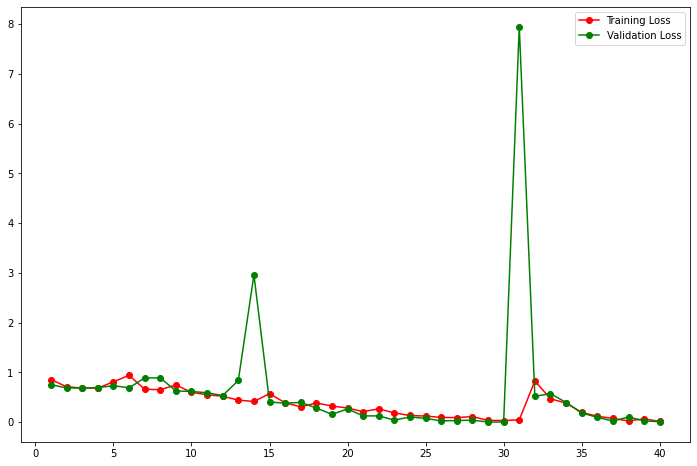

In [0]:
# Making the plot larger
plt.figure(figsize=(12, 8))

loss = history.history['loss']                          # Loss on the training data
val_loss = history.history['val_loss']                  # Loss on the validation data
epochs = range(1, 41)

plt.plot(epochs, loss, 'ro-', label='Training Loss')
plt.plot(epochs, val_loss, 'go-', label = 'Validation Loss')
plt.legend()

In [0]:
!mkdir "/content/gdrive/My Drive/Security Dataset/Model_Vandalism"

In [0]:
!cp "/content/Model_1_vandalism.weights.best.hdf5" "/content/gdrive/My Drive/Security Dataset/Model_Vandalism"
!cp "/content/Model_2.weights.best.hdf5" "/content/gdrive/My Drive/Security Dataset/Model_Vandalism"
!cp "/content/Model_3.weights.best.hdf5" "/content/gdrive/My Drive/Security Dataset/Model_Vandalism"


In [0]:
shutil.copytree("/content/curated_dataset","/content/gdrive/My Drive/Security Dataset/Model_Vandalism/curated_dataset") 

'/content/gdrive/My Drive/Security Dataset/Model_Vandalism/curated_dataset'

In [0]:
from sklearn.metrics import classification_report

In [0]:
y_pred=model.predict(X_test)
y_pred=y_pred>0.80
target_names = ['class Normal', 'class Vandalism']
print(classification_report(y_test, y_pred, target_names=target_names))

                 precision    recall  f1-score   support

   class Normal       0.96      0.98      0.97       129
class Vandalism       0.98      0.91      0.94       141

      micro avg       0.97      0.94      0.96       270
      macro avg       0.97      0.95      0.96       270
   weighted avg       0.97      0.94      0.96       270
    samples avg       0.94      0.94      0.94       270



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
